In [2]:
import geopandas as gpd
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import numpy as np

gm = gpd.read_parquet('data/gemeenten/gemeenten_stats.parquet')
wk = gpd.read_parquet('data/wijken/wijken_stats.parquet')
bu = gpd.read_parquet('data/buurten/buurten_stats.parquet')

# Transforming entropy


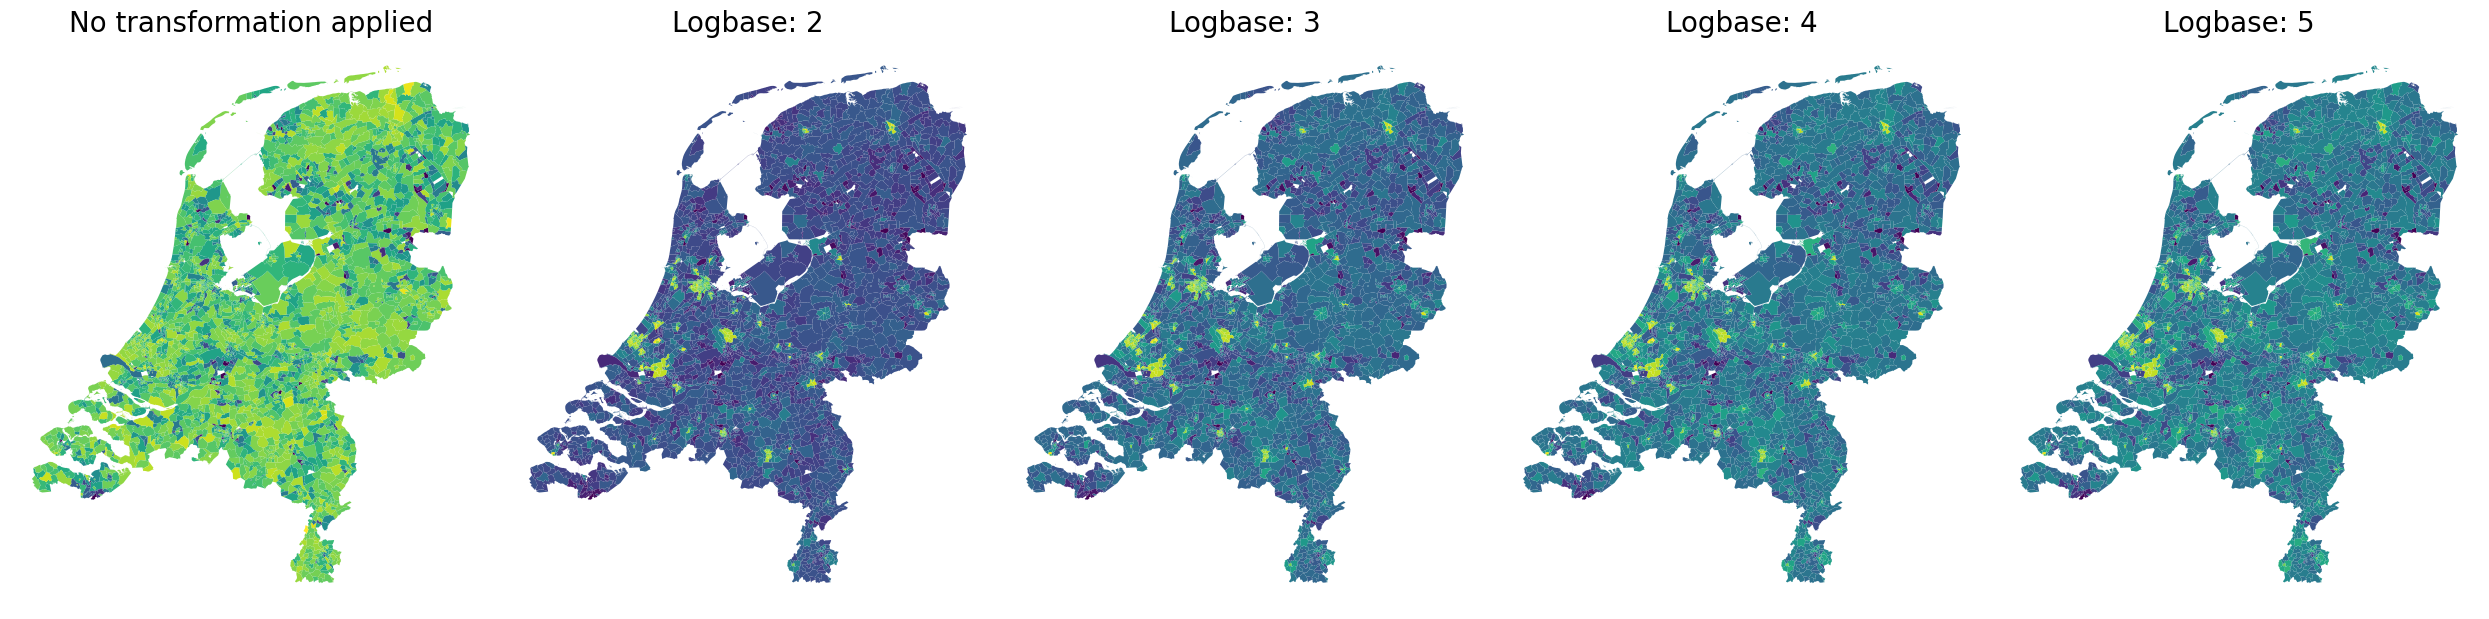

In [3]:
plot_amount = 5

fig, ax = plt.subplots(1, plot_amount, figsize=(5*plot_amount, 10))

wk.plot(column='L0_altieri_1', ax=ax[0])
ax[0].set_title('No transformation applied')

for i in range(2, plot_amount+1):
    wk.loc[:, f'T_{i}'] = wk.apply(lambda x: x.L0_altieri_1 / (np.emath.logn(i, x.STED)+1), axis=1) 
    wk.plot(column=f'T_{i}', ax=ax[i-1])
    ax[i-1].set_title(f'Logbase: {i}')

for a in ax:
    # title font size
    a.title.set_size(20)
    a.axis('off')
    
plt.tight_layout()

# plt.savefig('plots/altieri_transformations.png', dpi=100)
plt.show()

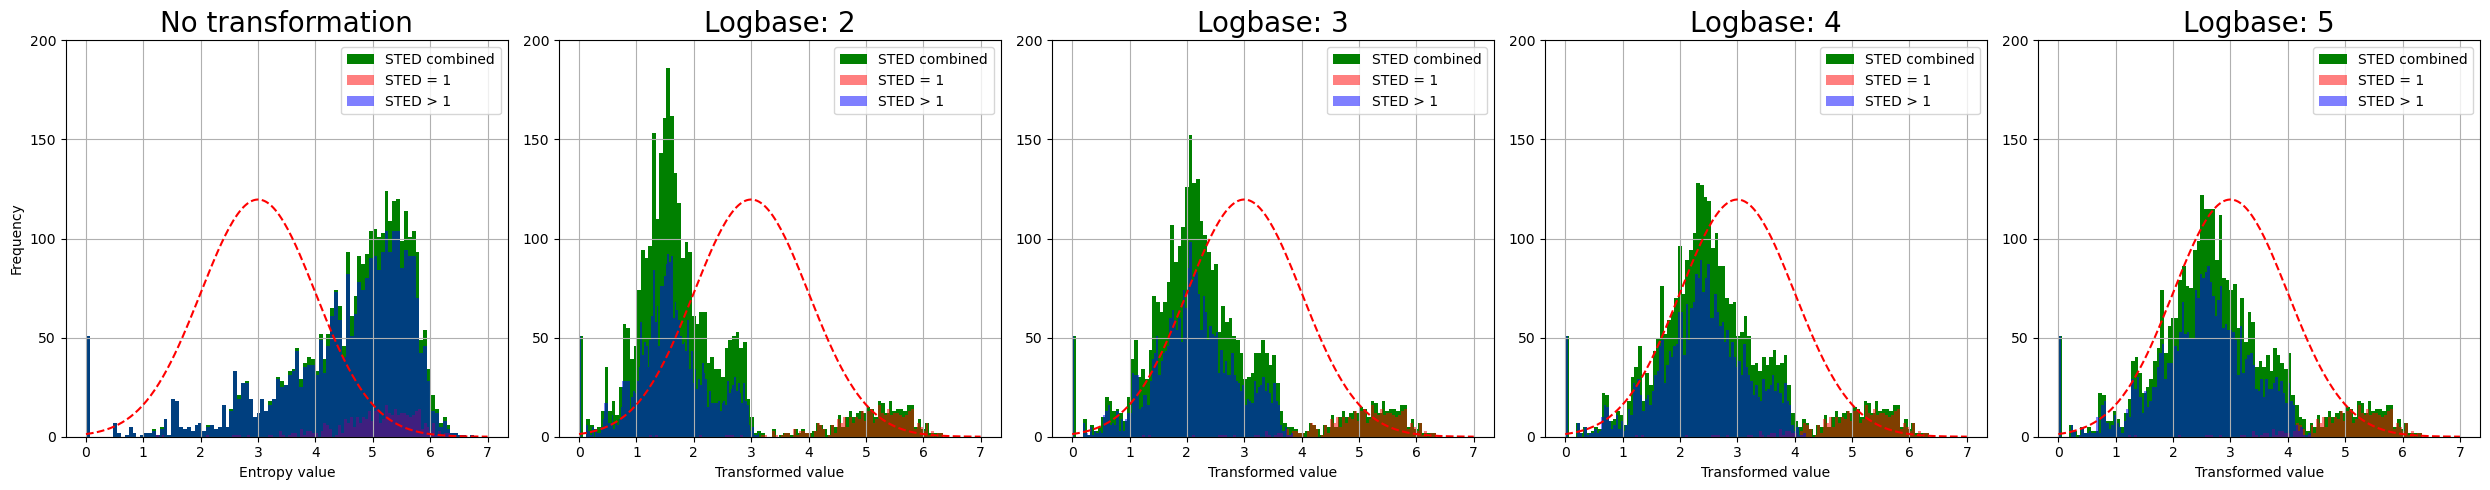

In [36]:
# Define a discrete color map
color_map = {1: 'red', 2: 'orange', 3: 'yellow', 4: 'green', 5: 'blue'}

# plot histogram of the transformed values
fig, ax = plt.subplots(1, plot_amount, figsize=(5*plot_amount, 5))

# histogram no transformation
wk.hist(column="L0_altieri_1", bins=100, ax=ax[0], color='green', alpha=1, label="STED combined")
wk[wk['STED'] == 1].hist(column=f'L0_altieri_1', bins=100, ax=ax[0], color='red', alpha=0.5, label=f'STED = 1')
wk[wk['STED'] > 1].hist(column=f'L0_altieri_1', bins=100, ax=ax[0], color='blue', alpha=0.5, label=f'STED > 1')
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Entropy value')
ax[0].set_title('No transformation')

# plot gaussian distribution for comparison
x = np.linspace(0, 7, 200)
mu = 3
sigma = 1
y = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
ax[0].plot(x, y*300, 'r--')
ax[0].set_yticks(np.arange(0, 201, 50))

for i in range(2, plot_amount+1):
    # histogram of T_i
    wk.hist(column=f'T_{i}', bins=100, ax=ax[i-1], color='green', alpha=1, label="STED combined")
    
    # for j in range(1, 6):
    #     wk[wk['STED'] == j].hist(column=f'T_{i}', bins=100, ax=ax[i-1], color=color_map[j], alpha=0.5, label=f'STED {j}')
    wk[wk['STED'] == 1].hist(column=f'T_{i}', bins=100, ax=ax[i-1], color='red', alpha=0.5, label=f'STED = 1')
    wk[wk['STED'] > 1].hist(column=f'T_{i}', bins=100, ax=ax[i-1], color='blue', alpha=0.5, label=f'STED > 1')
    
    # wk.hist(column=f'T_{i}', bins=100, ax=ax[i-1])
    ax[i-1].plot(x, y*300, 'r--')
    ax[i-1].set_title(f'Logbase: {i}')
    ax[i-1].set_xlabel('Transformed value')
    
    # set yticks to 0-200
    ax[i-1].set_yticks(np.arange(0, 201, 50))

# show labels
for a in ax:
    a.legend()
    a.title.set_size(20)
    
plt.tight_layout()
plt.savefig('plots/altieri_transformations_histogram.png', dpi=100)
plt.show()
    

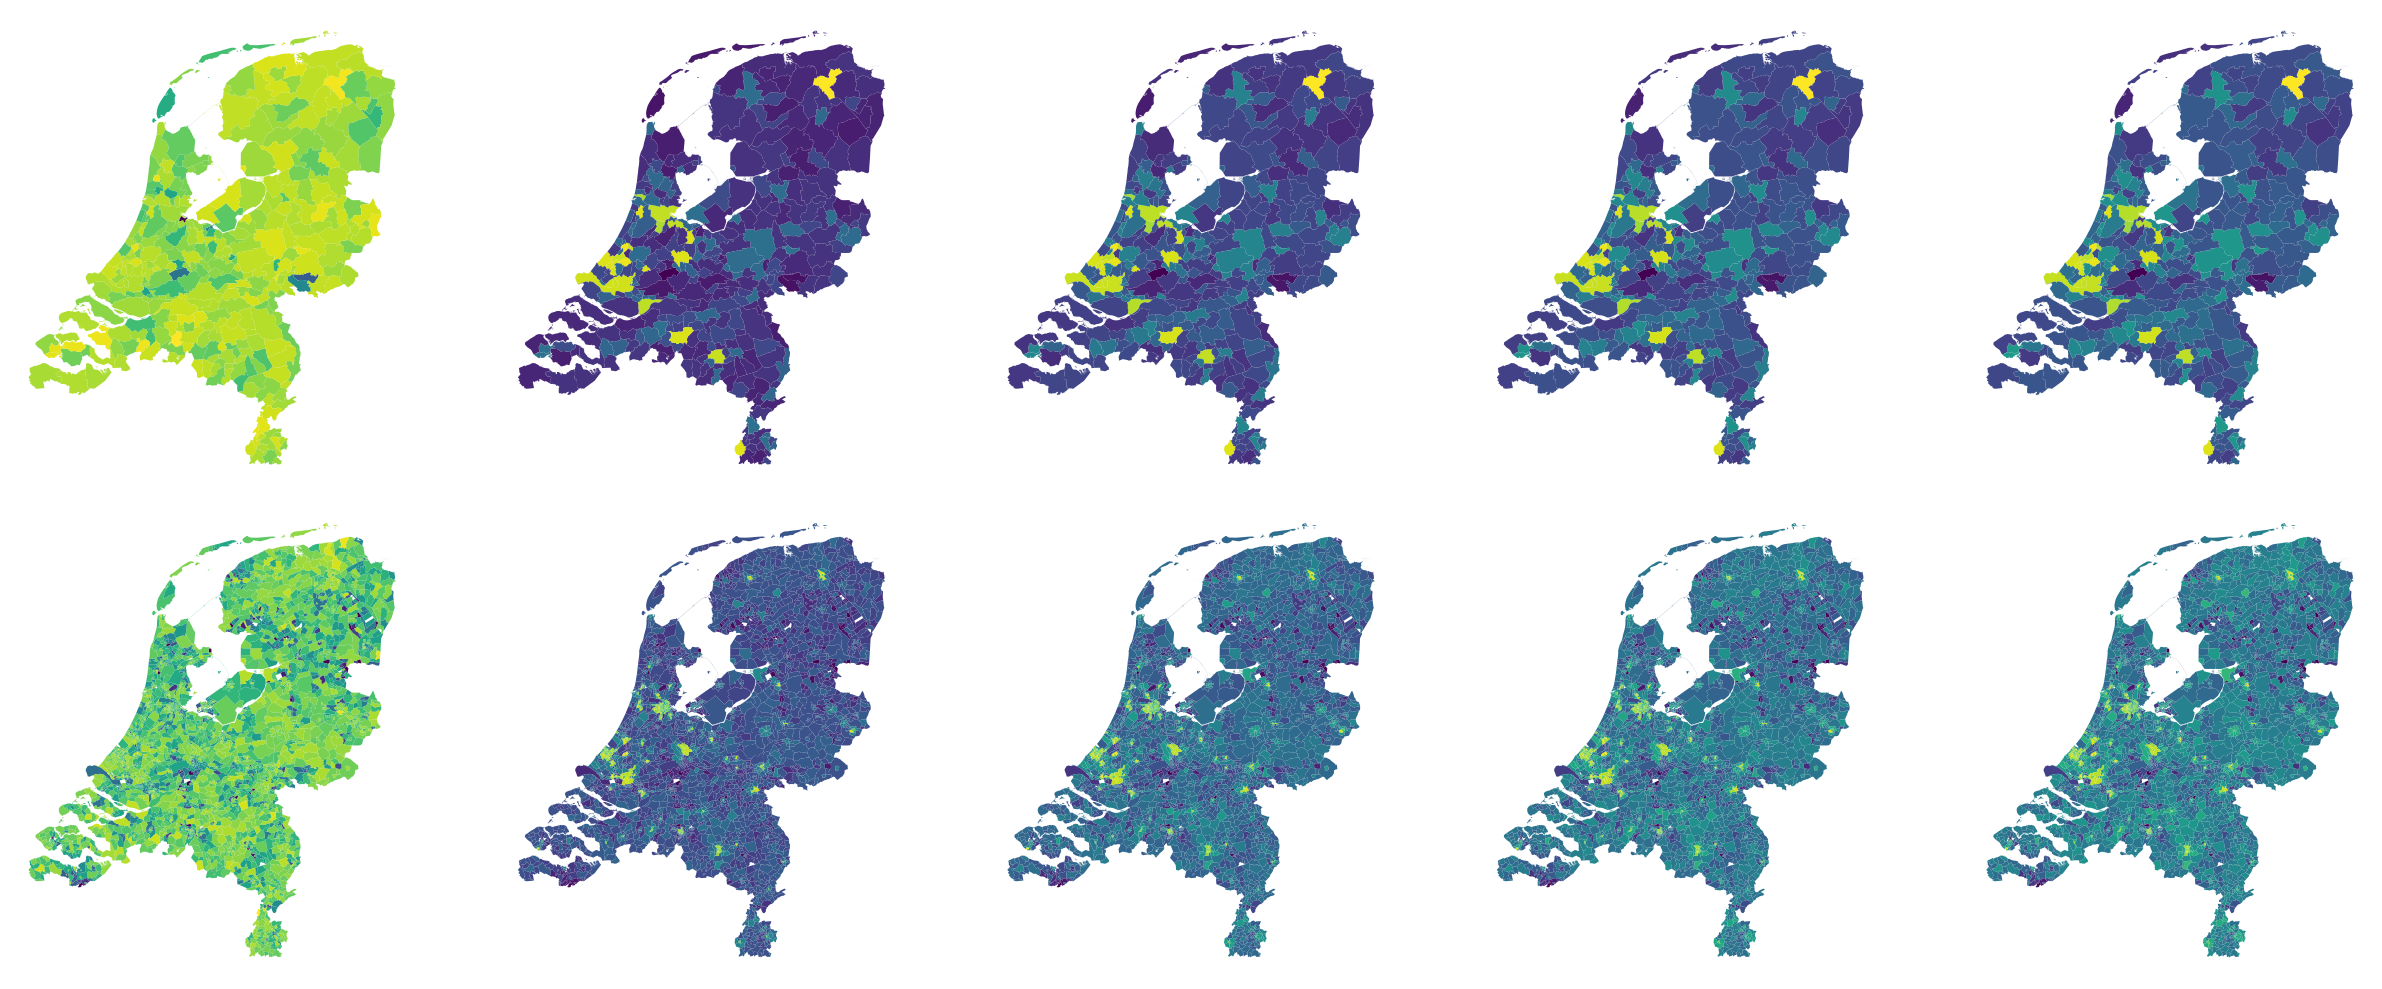

In [30]:
fig, axs = plt.subplots(2, 5, figsize=(25, 10))

gm.plot(column='L0_altieri_1', ax=axs[0, 0])
wk.plot(column='L0_altieri_1', ax=axs[1, 0])
# bu.plot(column='L0_altieri_1', ax=axs[2, 0])

for i, df in enumerate([gm, wk]):
    for j in range(2, 6):
        df.loc[:, f'T_{j}'] = df.apply(lambda x: x.L0_altieri_1 / (np.emath.logn(j, x.STED)+1), axis=1) 
        df.plot(column=f'T_{j}', ax=axs[i, j-1])

for a in axs.flatten():
    a.axis('off')
plt.tight_layout()
plt.show()

# Local spatial autocorrelation

In [31]:
from pysal.explore import esda
from pysal.lib import weights
from splot import esda as esdaplot

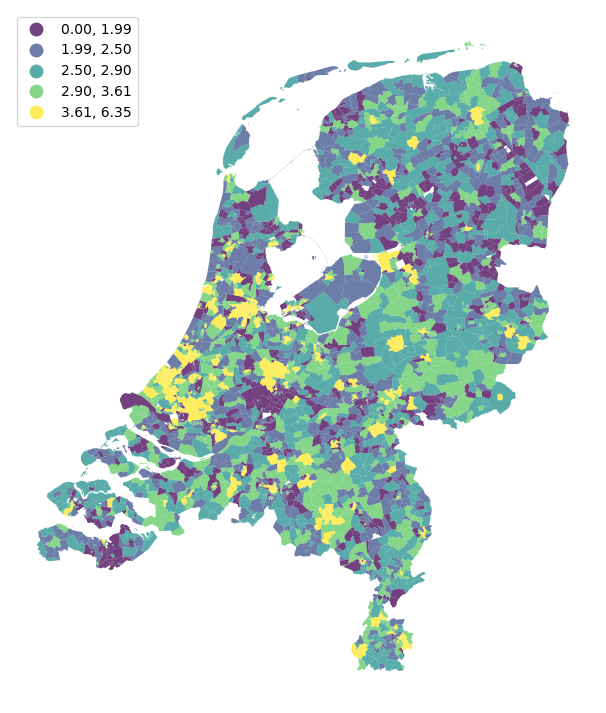

In [32]:
col = 'T_5'
db = wk.copy()

db.dropna(subset=["T_5"], inplace=True)
# Set up figure and a single axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Build choropleth
db.plot(
    column=col,
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax,
)

ax.set_axis_off()

<Axes: ylabel='Density'>

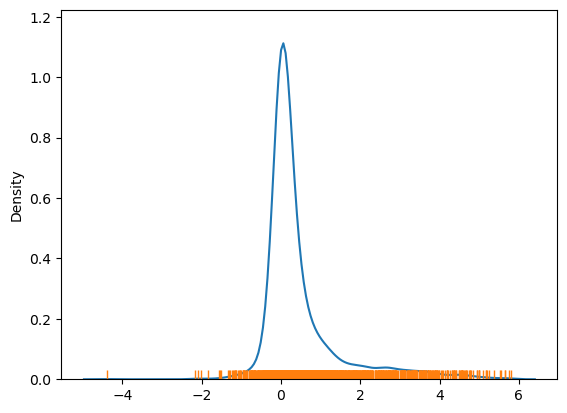

In [62]:
# Generate W from the GeoDataFrame, use 8 nearest neighbors

# set crs to epsg 4326
db.crs = 'EPSG:4326'

w = weights.KNN.from_dataframe(db, k=8)
# Row-standardization
w.transform = "R"

db[f"w_{col}"] = weights.lag_spatial(w, db[col])
lisa = esda.moran.Moran_Local(db[col], w)

# Draw KDE line
ax = sns.kdeplot(lisa.Is)
# Add one small bar (rug) for each observation
# along horizontal axis
sns.rugplot(lisa.Is, ax=ax)

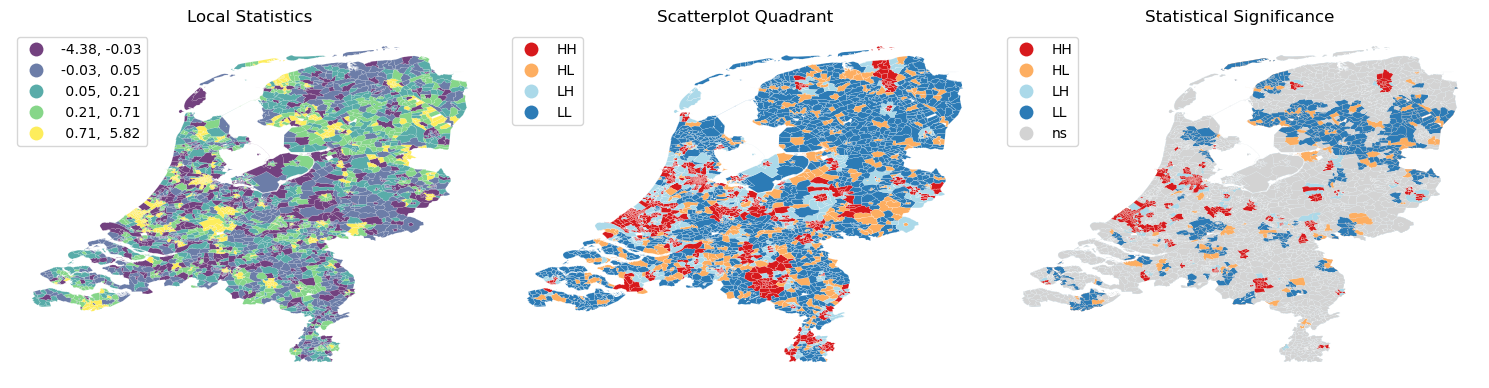

In [35]:
# change crs to epsg 3857 for plotly
db.crs = 'EPSG:3857'

# Set up figure and axes
f, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 #
# Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# Assign new column with local statistics on-the-fly
db.assign(
    Is=lisa.Is
    # Plot choropleth of local statistics
).plot(
    column="Is",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax,
)

# Subplot 2 #
# Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# Plot Quadrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa, db, p=1, ax=ax, legend=True, legend_kwds=dict(loc=2))

# Subplot 3 #
# Significance map
# Grab third axis of local statistics
ax = axs[2]
#
# Find out significant observations
labels = pd.Series(
    1 * (lisa.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=db.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})
# Assign labels to `db` on the fly
db.assign(
    cl=labels
    # Plot choropleth of (non-)significant areas
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax,
)


# Subplot 4 #
# Cluster map
# Grab second axis of local statistics
ax = axs[2]
# Plot Quadrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa, db, p=0.05, ax=ax, legend=True, legend_kwds=dict(loc=2))

# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
    )
# Tight layout to minimize in-between white space
f.tight_layout()

plt.savefig('plots/altieri_lisa.png', dpi=100)

# Display the figure
plt.show()

3299